# Powergrid library construction and zero gamma data

$\Gamma = 0$,

Perburbations = large

In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import coo_array

## Loading data

#### Reading gamma values 

In [4]:
gamma_df = pd.read_csv("powergrid/Datasets/case_4bus2gen_largeperturb/case_4bus2gen_gamma.csv")

In [5]:
gamma_df

#### Reading time series data and skipping rows to sub sample

In [6]:
data_matrix_df_orig = pd.read_csv("powergrid/Datasets/case_4bus2gen_largeperturb/case_4bus2gen_timeseries.csv")

In [7]:
skip_n_rows_btw = 100
rows_to_keep = np.arange(0, len(data_matrix_df_orig), skip_n_rows_btw)

In [8]:
data_matrix_df = data_matrix_df_orig.iloc[rows_to_keep].reset_index(drop=True)

In [9]:
new_column_names = ["time", "Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
                   "om_0", "om_1", "P_0", "P_1", "P_2", "P_3", "P_4", "P_5",
                   "Q_0", "Q_1", "Q_2", "Q_3", "Q_4", "Q_5"]
data_matrix_df.rename(columns=dict((zip(data_matrix_df.columns, new_column_names))),
                     inplace=True)

In [10]:
data_matrix_df = data_matrix_df[["time", "Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
                   "om_0", "om_1", "P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]]

data_matrix_df

In [11]:
data_matrix_df.columns

#### Loading admittance matrix, Y

In [12]:
admittance_Y_df = pd.read_csv("powergrid/Datasets/case_4bus2gen_largeperturb/case_4bus2gen_Y.csv")
for column in admittance_Y_df.columns:
    admittance_Y_df[column] = admittance_Y_df[column].apply(lambda x: x.replace('i', 'j'))

In [13]:
admittance_Y_df

#### Loading static parameters

In [14]:
static_param_df = pd.read_csv("powergrid/Datasets/case_4bus2gen_largeperturb/case_4bus2gen_staticparams.csv")

In [15]:
static_param_df

#### Loading coupling matrix, K

In [16]:
coupling_K_df = pd.read_csv("powergrid/Datasets/case_4bus2gen_largeperturb/case_4bus2gen_K.csv")

In [17]:
coupling_K_df_labeled = coupling_K_df.set_index(coupling_K_df.columns)
coupling_K_df_labeled

## Forming candidate library for powersystems

In [18]:
gamma_df

In [19]:
gamma_matrix = gamma_df.to_numpy()
admittance_Y_matrix = admittance_Y_df.to_numpy()

gamma_matrix

In [20]:
coupling_matrix_init = np.ones(admittance_Y_matrix.shape)
# coupling_matrix_init = np.zeros(admittance_Y_matrix.shape)
# coupling_matrix_init[3,:] = 1

coupling_matrix_init = np.triu(coupling_matrix_init, 0)
coupling_matrix_init
sparse_coupling_matrix_init = coo_array(coupling_matrix_init)
sparse_coupling_matrix_init.toarray()

### Defining the sin interaction terms 

In [21]:
from dae_finder import FeatureCouplingTransformer

def coup_fun(x,y,i,j,gam_matrix):
    return np.sin(x-y- gam_matrix[i,j])

def coup_namer(x,y,i,j,gam_matrix):
    return "sin( {}-{} -gamma_{},{} )".format(x,y,i,j)
    

dummy_tr_sin_diff = FeatureCouplingTransformer(sparse_coupling_matrix_init,
                                           coupling_func= coup_fun,
                                           coupling_namer= coup_namer,
                                           coupling_func_args={"gam_matrix":gamma_matrix},
                                              return_df=True)

In [22]:
sin_diff_library = dummy_tr_sin_diff.fit_transform(data_matrix_df.drop(["time"], axis=1))
cop_ind = dummy_tr_sin_diff.coupled_indices_list

# cop_ind

In [23]:
sin_diff_library

In [24]:
candidate_lib = pd.concat([data_matrix_df.drop("time", axis=1), sin_diff_library], axis=1)

In [25]:
candidate_lib

## Finding Algebraic relationship

### Using sympy to find factors of redundant feature and refine the library

In [26]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

# Using Lasso

## Finding the conservation laws

In [27]:
from dae_finder import sequentialThLin, AlgModelFinder
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       alpha=0.3,
                                       fit_intercept=True)

In [28]:
algebraic_model_lasso.fit(candidate_lib, scale_columns= True,
                          features_to_fit=["Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
                                          "P_0", "P_1", "P_2", "P_3", "P_4", "P_5"])

In [29]:
algebraic_model_lasso.best_models()

In [62]:
algebraic_model_lasso.best_models()["P_1"][abs(algebraic_model_lasso.best_models()["P_1"])>0.01]

In [36]:
feat = "P_5"
algebraic_model_lasso.best_models()[feat][abs(algebraic_model_lasso.best_models()[feat])>0.1]

# Using Sequential Thresholding

In [113]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression
lin_reg_model = LinearRegression
lin_reg_model_arg = {"fit_intercept": False}
seq_th_model = sequentialThLin(custom_model=True,
                               custom_model_ob = lin_reg_model,
                               custom_model_arg= lin_reg_model_arg,
                              coef_threshold=0.5)
# seq_th_model = sequentialThLin(coef_threshold=0.1, fit_intercept=True)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

In [114]:
algebraic_model_th.fit(candidate_lib, scale_columns= False,
                          features_to_fit=["Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
                                          "P_0", "P_1", "P_2", "P_3", "P_4", "P_5"])

In [115]:
#Best 10 models using R2 metrix
algebraic_model_th.best_models()

In [116]:
algebraic_model_th.get_fitted_intercepts()

In [117]:
feat = "P_2"
algebraic_model_th.best_models()[feat][abs(algebraic_model_th.best_models()[feat])>0.1]

## Finding the conservation laws

In [27]:
from dae_finder import sequentialThLin, AlgModelFinder
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       alpha=0.3,
                                       fit_intercept=True)

In [28]:
algebraic_model_lasso.fit(candidate_lib, scale_columns= True,
                          features_to_fit=["Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
                                          "P_0", "P_1", "P_2", "P_3", "P_4", "P_5"])

In [29]:
algebraic_model_lasso.best_models()

In [30]:
algebraic_model_lasso.best_models()["P_1"][abs(algebraic_model_lasso.best_models()["P_1"])>0.01]

In [36]:
feat = "P_5"
algebraic_model_lasso.best_models()[feat][abs(algebraic_model_lasso.best_models()[feat])>0.1]

In [96]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [97]:
lin_model = LinearRegression()
lass_model = Lasso(alpha=0.01)
ridge_model = Ridge()

In [83]:
lin_model.fit(candidate_lib[['sin( Phi_3-Phi_0 -gamma_3,0 )', 'sin( Phi_3-Phi_1 -gamma_3,1 )',
       'sin( Phi_3-Phi_2 -gamma_3,2 )', 'sin( Phi_3-Phi_3 -gamma_3,3 )',
       'sin( Phi_3-Phi_4 -gamma_3,4 )', 'sin( Phi_3-Phi_5 -gamma_3,5 )']], candidate_lib["P_3"])

In [98]:
lass_model.fit(candidate_lib[['sin( Phi_3-Phi_0 -gamma_3,0 )', 'sin( Phi_3-Phi_1 -gamma_3,1 )',
       'sin( Phi_3-Phi_2 -gamma_3,2 )', 'sin( Phi_3-Phi_3 -gamma_3,3 )',
       'sin( Phi_3-Phi_4 -gamma_3,4 )', 'sin( Phi_3-Phi_5 -gamma_3,5 )']], candidate_lib["P_3"])

ridge_model.fit(candidate_lib[['sin( Phi_3-Phi_0 -gamma_3,0 )', 'sin( Phi_3-Phi_1 -gamma_3,1 )',
       'sin( Phi_3-Phi_2 -gamma_3,2 )', 'sin( Phi_3-Phi_3 -gamma_3,3 )',
       'sin( Phi_3-Phi_4 -gamma_3,4 )', 'sin( Phi_3-Phi_5 -gamma_3,5 )']], candidate_lib["P_3"])

In [84]:
lin_model.coef_

In [93]:
lass_model.coef_

In [99]:
ridge_model.coef_

In [100]:
ridge_model.score(candidate_lib[['sin( Phi_3-Phi_0 -gamma_3,0 )', 'sin( Phi_3-Phi_1 -gamma_3,1 )',
       'sin( Phi_3-Phi_2 -gamma_3,2 )', 'sin( Phi_3-Phi_3 -gamma_3,3 )',
       'sin( Phi_3-Phi_4 -gamma_3,4 )', 'sin( Phi_3-Phi_5 -gamma_3,5 )']], candidate_lib["P_3"])

In [94]:
lass_model.score(candidate_lib[['sin( Phi_3-Phi_0 -gamma_3,0 )', 'sin( Phi_3-Phi_1 -gamma_3,1 )',
       'sin( Phi_3-Phi_2 -gamma_3,2 )', 'sin( Phi_3-Phi_3 -gamma_3,3 )',
       'sin( Phi_3-Phi_4 -gamma_3,4 )', 'sin( Phi_3-Phi_5 -gamma_3,5 )']], candidate_lib["P_3"])

In [85]:
lin_model.score(candidate_lib[['sin( Phi_3-Phi_0 -gamma_3,0 )', 'sin( Phi_3-Phi_1 -gamma_3,1 )',
       'sin( Phi_3-Phi_2 -gamma_3,2 )', 'sin( Phi_3-Phi_3 -gamma_3,3 )',
       'sin( Phi_3-Phi_4 -gamma_3,4 )', 'sin( Phi_3-Phi_5 -gamma_3,5 )']], candidate_lib["P_3"])

In [80]:
candidate_lib.columns

In [82]:
candidate_lib[['sin( Phi_3-Phi_0 -gamma_3,0 )', 'sin( Phi_3-Phi_1 -gamma_3,1 )',
       'sin( Phi_3-Phi_2 -gamma_3,2 )', 'sin( Phi_3-Phi_3 -gamma_3,3 )',
       'sin( Phi_3-Phi_4 -gamma_3,4 )', 'sin( Phi_3-Phi_5 -gamma_3,5 )']]

### Finding the remaining algebraic relationships

In [60]:
features_to_remove = {E}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=False, alpha=0.2)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)

In [218]:
admittance_Y_df

In [266]:
gamma_matrix

In [84]:
lin_model.coef_

In [102]:
candidate_lib[['sin( Phi_3-Phi_0 -gamma_3,0 )', 'sin( Phi_3-Phi_1 -gamma_3,1 )',
       'sin( Phi_3-Phi_2 -gamma_3,2 )', 'sin( Phi_3-Phi_3 -gamma_3,3 )',
       'sin( Phi_3-Phi_4 -gamma_3,4 )', 'sin( Phi_3-Phi_5 -gamma_3,5 )']].plot()

In [109]:
data_matrix_df.drop(["time", "P_0","P_1","P_2","P_3","P_4","P_5", "om_0", "om_1"], axis=1).plot()

In [112]:
data_matrix_df[["P_0","P_1","P_2","P_3","P_4","P_5"]].plot()

In [10]:
from scipy import interpolate

In [11]:
#smoothing parameter: when equal weightage: num_data_points * std of data
s_param = num_time_points * (0.01*noise_perc*data_matrix_df_list[1].std()["x"])**2

tck = interpolate.splrep(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], s=s_param)
t_eval_new = np.linspace(t_span[0], t_span[1], 500)
x_new = interpolate.splev(t_eval_new, tck, der=0)

plt.figure()
plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
        data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")
plt.legend(['Linear', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation')
plt.show()

In [12]:
(3/4)*np.pi

In [13]:
data_matrix_df[["x","y"]].plot()

### Smoothing data and finding derivatives

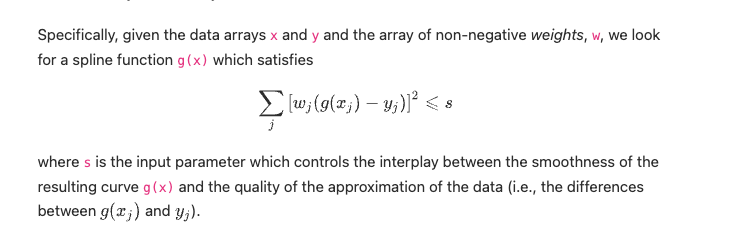

from dae_finder import der_matrix_calculator

from scipy import interpolate

def der_label(feature, der=1):
    if der==0:
        return feature
    elif der==1:
        return "d({}) /dt".format(feature)
    else:
        return "d^{}({}) /dt^{}".format(der, feature, der)

def smooth_data(data_matrix, domain_var = "t", s_param=None, noise_perc=0, derr_order = 1, eval_points = []):
    assert domain_var in data_matrix, "domain variable not found in the data matrix"

    data_t = data_matrix[domain_var]
    num_time_points = len(data_matrix)
    find_s_param = !s_param and s_param !=0

    if len(eval_points)==0:
        eval_points = np.linspace(data_t.iloc[0], data_t.iloc[-1], 10*num_time_points)
    t_eval_new = eval_points
               
    data_matrix_ = data_matrix.drop(domain_var, axis=1)
    data_matrix_std = data_matrix_.std()

    data_matrix_smooth = pd.DataFrame(t_eval_new, columns=[domain_var])
    for feature in data_matrix_:
        if find_s_param:
            #smoothing parameter: when equal weightage: num_data_points * std of data
            s_param = num_time_points * (0.01*noise_perc*data_matrix_std[feature])**2
        tck = interpolate.splrep(data_t, data_matrix_[feature], s=s_param)
        for der_ind in range(derr_order+1):
            smoothed_data = interpolate.splev(t_eval_new, tck, der=der_ind)
            data_matrix_smooth[der_label(feature, der_ind)] = smoothed_data

    return data_matrix_smooth
    



t_eval_new = np.linspace(data_matrix_df_list[1]["t"].iloc[0], data_matrix_df_list[1]["t"].iloc[-1], num_smoothed_points)

smooth_data(data_matrix_df_list[1],derr_order=1, eval_points=t_eval_new, noise_perc=noise_perc) - data_matrix_smooth_df_list[1]

delta_t = t_eval_[1]- t_eval_[0]
data_matrix_features = data_matrix_df_list[0].columns
num_smoothed_points = num_time_points*10
data_matrix_smooth_df_list = []

for ind, data_matrix in enumerate(data_matrix_df_list):
    data_t = data_matrix["t"]
    num_time_points = len(data_matrix)
    data_matrix_ = data_matrix.drop(["t"], axis=1)
    data_matrix_std = data_matrix_.std()
    # print(data_matrix_std)
    t_eval_new = np.linspace(data_t.iloc[0], data_t.iloc[-1], num_smoothed_points)
    data_matrix_smooth = pd.DataFrame(t_eval_new, columns=["t"])
    for feature in data_matrix_:
        #smoothing parameter: when equal weightage: num_data_points * std of data
        s_param = num_time_points * (0.01*noise_perc*data_matrix_std[feature])**2
        # print(s_param)
        # s_param = 0
        
        tck = interpolate.splrep(data_t, data_matrix_[feature], s=s_param)
        smoothed_data = interpolate.splev(t_eval_new, tck, der=0)
        smoothed_derr = interpolate.splev(t_eval_new, tck, der=1)
        data_matrix_smooth[feature] = smoothed_data
        data_matrix_smooth["d({}) /dt".format(feature)] = smoothed_derr

    data_matrix_smooth_df_list.append(data_matrix_smooth)

    
    # derr_matrix = der_matrix_calculator(data_matrix_, delta_t)
    # data_matrix_df_list[ind] = pd.concat([data_matrix_.iloc[:-1], derr_matrix], axis=1)

data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list[:-1], ignore_index=True)

In [14]:
from dae_finder import smooth_data

num_smoothed_points = num_time_points*10

t_eval_new = np.linspace(data_matrix_df_list[0]["t"].iloc[0], data_matrix_df_list[0]["t"].iloc[-1], num_smoothed_points)

#Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix,derr_order=1, noise_perc=noise_perc, eval_points=t_eval_new) for data_matrix in data_matrix_df_list]

data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list[:-1], ignore_index=True)

In [15]:
ind = 1
feature_ = "y"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["t"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["t"],
         data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["t"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

In [16]:
data_matrix_smooth_df_list[0][["d(x) /dt"]].plot()

In [17]:
data_matrix_smooth_df_list[0][["d(x) /dt"]].plot()

#Taking second derivatives
delta_t = t_eval_[1]- t_eval_[0]
data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    derr_matrix = der_matrix_calculator(data_matrix_, delta_t)
    data_matrix_df_list[ind] = pd.concat([data_matrix_.iloc[:-1], derr_matrix], axis=1)

data_matrix_df_appended = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df_appended

In [18]:
# data_matrix_df = data_matrix_df_appended[["x","y"]]
# data_matrix_df = pd.concat([data_matrix_df, data_matrix_df_appended[["d(u) /dt"]]], axis=1)
data_matrix_df_smooth = data_matrix_df_smooth_appended[["x","y", "d(x) /dt", "d(y) /dt"]]
data_matrix_df_smooth

In [19]:
from copy import deepcopy
new_df = deepcopy(data_matrix_df_smooth)

new_df["energy"] = 0.5*((new_df["d(x) /dt"])**2 + (new_df["d(y) /dt"])**2) +  9.81*new_df["y"]

new_df.plot()

## Forming candiate library

In [20]:
from sklearn.preprocessing import FunctionTransformer
from copy import deepcopy

def sin_transformer(period = 2*np.pi):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def sin_diff_transformer(period = 2*np.pi):
    return FunctionTransformer(lambda x,y: np.sin((x-y) / period * 2 * np.pi))

def cos_transformer(period = 2*np.pi):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def sin_shift_transformer(period = 2*np.pi):
    return FunctionTransformer(lambda x,y: np.sin((x-y) / period * 2 * np.pi))

data_matrix_df_with_trig = deepcopy(data_matrix_df)
# data_matrix_df_with_trig["sin(theta)"] = sin_transformer(1).fit_transform(data_matrix_df_with_trig)["theta"]
# data_matrix_df_with_trig["cos(theta)"] = cos_transformer(1).fit_transform(data_matrix_df_with_trig)["theta"]

In [148]:
from scipy.sparse import coo_array

row  = np.array([0, 3, 1, 0, 0, 0])
col  = np.array([0, 3, 1, 1, 2, 4])
data = np.array([4, 5, 7, 9, 100, 101])
# sp_array = coo_array((data, (row, col)), shape=(4, 4))
sp_array = coo_array((data, (row, col)))


In [22]:
list(zip(sp_array.row, sp_array.col))

In [30]:
from dae_finder import FeatureCouplingTransformer

from scipy.sparse import coo_array

row  = np.array([0, 0, 1, 1])
col  = np.array([0, 2, 2, 1])
data = np.array([4, 5, 7, 5])
sp_array_2 = coo_array((data, (row, col)))


In [39]:
np.triu(np.ones((3,3)), 1)

### Defining the sin interaction terms 

In [26]:
phi_matrix = np.array([[1,2,3],[4,5,6],[7,8,9]])

def coup_fun(x,y,i,j,ph_matrix):
    return np.sin(x-y- ph_matrix[i,j])

def coup_namer(x,y,i,j,ph_matrix):
    return "sin( {}-{} -phi_{},{} )".format(x,y,i,j)
dummy_tr_sin_diff = FeatureCouplingTransformer(sp_array_2,
                                           coupling_func= coup_fun,
                                           coupling_namer= coup_namer,
                                           coupling_func_args={"ph_matrix":phi_matrix},
                                              return_df=True)

In [27]:
new_data = dummy_tr_sin_diff.fit_transform(data_matrix_)
cop_ind = dummy_tr_sin_diff.coupled_indices_list

cop_ind

In [28]:
# dummy_tr._check_n_features(data_matrix_, 0)
# dummy_tr._check_feature_names(data_matrix_, reset = 0)

In [29]:
new_data

In [29]:
new_data_diff = dummy_tr_diff.fit_transform(data_matrix_)
cop_ind_diff = dummy_tr_diff.coupled_indices_list

cop_ind

In [30]:
new_data_diff_minus_k = dummy_tr_diff_minus_k.fit_transform(data_matrix_)
cop_ind_diff_minus_k = dummy_tr_diff_minus_k.coupled_indices_list

cop_ind

In [31]:
new_data = dummy_tr.fit_transform(data_matrix_)
cop_ind = dummy_tr.coupled_indices_list

cop_ind

In [32]:
dummy_tr_diff.get_feature_names_out()

In [33]:
dummy_tr.get_feature_names_out()

In [45]:
dummy_tr_sin_diff.get_feature_names_out()

In [35]:
def du_2(a,b=100,c=200):
    print(a,b,c)
    

In [36]:
def du(a,**kwargs):
    # print(a)
    du_2(a, **kwargs)
    

In [207]:
du(2, b=33, c=44)

In [196]:
du(2, **{"b": 3, "c":4})

In [78]:
list(zip(dummy_tr.sparsity_matrix.row, dummy_tr.sparsity_matrix.col))

In [73]:
sp_array_2.toarray()

In [110]:
x_out = np.zeros((dummy_tr.fit_transform(data_matrix_).shape[0], len(dummy_tr.coupled_indices_list)))
x_out

In [258]:
new_data_diff_minus_k[:,3]

In [262]:
data_matrix_["t"] - data_matrix_["y"] - 2 - new_data_diff_minus_k[:,1]

In [35]:
dummy_tr.get_feature_names_out()

In [36]:
dummy_tr.get_feature_names_out()

In [109]:
a= np.array([1,2,3])
b = np.array([4,5,6])
c = np.array([7,8,9])


np.vstack((a,b,c)).transpose()

In [55]:
dummy_tr.fit(data_matrix_)
dummy_tr.fit_transform(data_matrix_)

In [30]:
dummy_tr.fit_transform(data_matrix_)[:,0]

In [27]:
dummy_tr.get_feature_names_out()

In [28]:
sp_array.coords

In [29]:
sp_array.toarray()

In [34]:
sp_array.coords

In [39]:
for el1, el2 in zip(sp_array.row, sp_array.col):
    print(el1, el2)

In [141]:
coo_array(sp_array.toarray()).nnz

In [137]:
sp_array.size

In [138]:
sp_array.nnz

In [33]:
np.triu(np.ones((4,4)))

In [41]:
data_matrix_

In [107]:
sp_array.ndim

In [115]:
max(sp_array.col.max(), sp_array.row.max())

In [114]:
sp_array.row.max()

In [23]:
sp_array.col

In [24]:
sp_array.toarray()[0]

In [26]:
new_sp = sp_array.tocsr()

In [148]:
new_sp.toarray()

In [152]:
col_sp = new_sp[[0]]
col_sp.col

In [172]:
#Getting rows corresponding to 1 and 2
new_sp[[0, 1,2]]

In [165]:
#Getting rows corresponding to 0 and 1
new_sp[:, [0,1]]

In [173]:
#Getting rows corresponding to 1 and 2
new_sp[[0, 1,2]].toarray()

In [167]:
#Getting rows corresponding to 0 and 1
new_sp[:, [0,1]].toarray()

In [175]:
#Getting rows corresponding to 1 and 2
new_sp[[0, 1,2]].tocoo().row
# new_sp[[1,2]].tocoo().col


In [177]:
new_sp[[0, 1,2]].tocoo().col


In [167]:
#Getting rows corresponding to 0 and 1
new_sp[:, [0,1]].toarray()

In [ ]:
new_sp[[1,2]]

In [161]:
new_sp.getrow(1)

In [164]:
new_sp.getcol(1)

In [48]:
np.sin(data_matrix_df_with_trig) - sin_trans_obj.fit_transform(data_matrix_df_with_trig)

In [47]:
sin_trans_obj = sin_transformer()
sin_trans_obj.fit_transform(data_matrix_df_with_trig)

In [21]:
from dae_finder import PolyFeatureMatrix

poly_feature_ob = PolyFeatureMatrix(2)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)

In [22]:
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

candid_lib_comb = pd.concat([candidate_lib_full, data_matrix_df_with_trig[["cos(theta)", "sin(theta)"]]], axis=1)
candid_lib_comb

### SVD analysis

In [23]:
from sklearn import decomposition
pca_1 = decomposition.PCA()
pca_1.fit(candidate_lib_full)

# pca_2 = decomposition.PCA()
# pca_2.fit(mean_candidate_lib)

# pca_3 = decomposition.PCA()
# pca_3.fit(selected_data_matrix_df)

pca_2 = decomposition.PCA()
pca_2.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt"],axis=1))

pca_3 = decomposition.PCA()
pca_3.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt", "y"],axis=1))


# singular_values = pca_1.singular_values_
# mean_singular_values = pca_2.singular_values_

var_expl_ratio = pca_1.explained_variance_ratio_
theta_dot_sq_rem_expl_ratio = pca_2.explained_variance_ratio_
theta_dot_rem_expl_ratio = pca_3.explained_variance_ratio_
# data_var_expl_ratio_E = pca_4.explained_variance_

# var_expl_ratio_E_rem = pca_5.explained_variance_


In [24]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(var_expl_ratio)),np.log(var_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

In [25]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(theta_dot_sq_rem_expl_ratio)),np.log(theta_dot_sq_rem_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

In [26]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(theta_dot_rem_expl_ratio)),np.log(theta_dot_rem_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

### Finding the remaining algebraic relationships

In [27]:
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder


seq_th_model = sequentialThLin(fit_intercept=True, coef_threshold= 0.1)


algebraic_model_th.fit(candidate_lib_full, scale_columns= False)

In [28]:
seq_th_model = sequentialThLin(fit_intercept=True, coef_threshold= 0.05)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt"], axis=1), scale_columns= False)

In [27]:
algebraic_model_th.best_models(5)

In [28]:
#Use lasso model by default
algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.3, fit_intercept=True)
algebraic_model_1.fit(candidate_lib_full, scale_columns= True)


algebraic_model_1.best_models(5)

In [29]:
#Use lasso model by default
algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.3, fit_intercept=True)
algebraic_model_1.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt"], axis=1), scale_columns= True)


algebraic_model_1.best_models(5)

In [1701]:
from sklearn.linear_model import LinearRegression

In [1702]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["d(y) /dt^2", "d(x) /dt^2"]], y=candidate_lib_full["y"])

In [1648]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

In [1555]:
model_lin.intercept_

In [1556]:
# Expected coefficient of x_dot^2 and y_dot^2 
1/(9.8*2) #1/2 * 1/g

In [1557]:
# Expected intercept (coming from energy)
L #L

In [1558]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["y^2", "d(y) /dt^2"]], y=candidate_lib_full["x^2"])

In [1559]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

In [1446]:
model_lin.intercept_

In [181]:
%history -g

 1/1:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.5f}'.format)

import operator
 1/2:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.5f}'.format)

import operator
 2/1:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
 2/2:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Function to compute derivatives
def pendulum_rhs(t, y, gamma, L=1):
    """
    Function to compute derivatives for simple pendulum with damping
    
    Parameters:
        t : float
            Time
        y : array_like
            Vector containing [theta, omega], where
            theta is the angle and omega is the angular velocity
        gamma : float
            Damping coefficient
 

In [182]:
%history

import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import coo_array
gamma_df = pd.read_csv("powergrid/Datasets/case_4bus2gen_largeperturb/case_4bus2gen_gamma.csv")
gamma_df
data_matrix_df_orig = pd.read_csv("powergrid/Datasets/case_4bus2gen_largeperturb/case_4bus2gen_timeseries.csv")
skip_n_rows_btw = 100
rows_to_keep = np.arange(0, len(data_matrix_df_orig), skip_n_rows_btw)
data_matrix_df = data_matrix_df_orig.iloc[rows_to_keep].reset_index(drop=True)
new_column_names = ["time", "Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
                   "om_0", "om_1", "P_0", "P_1", "P_2", "P_3", "P_4", "P_5",
                   "Q_0", "Q_1", "Q_2", "Q_3", "Q_4", "Q_5"]
data_matrix_df.rename(columns=dict((zip(data_matrix_df.columns, new_column_names))),
                   